<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/ChromatinClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essential downloads

In [1]:
!wget -q -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1KriedE029fLEmQP3Jy_b6H-j0eRa_Icj&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip -q downloaded_file.zip

In [2]:

!pip -q install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn git+https://github.com/funkelab/funlib.learn.torch.git
!pip -q install openpyxl


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 10.3 MB/s

In [3]:

import os
import glob
import imageio.v2 as iio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
import torch.nn.functional as F
from funlib.learn.torch.models import Vgg3D

# Data Analyze

## Visualize

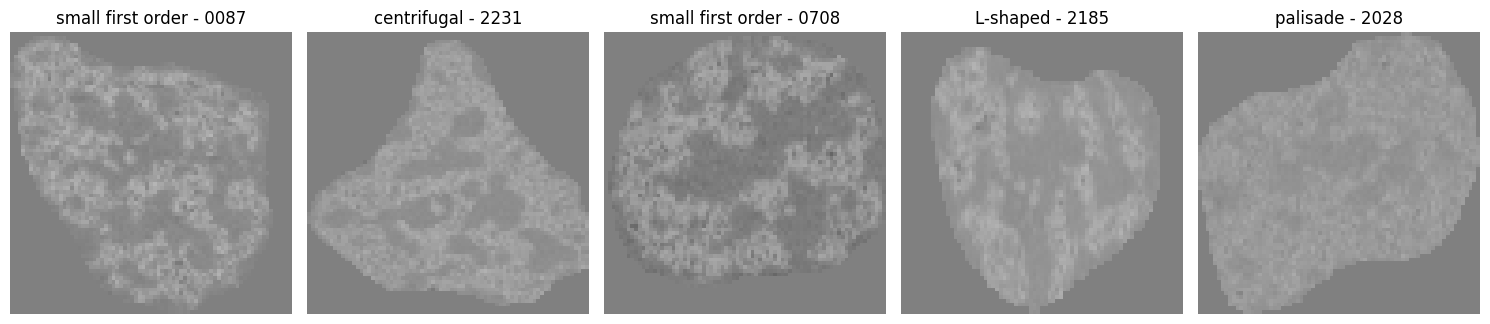

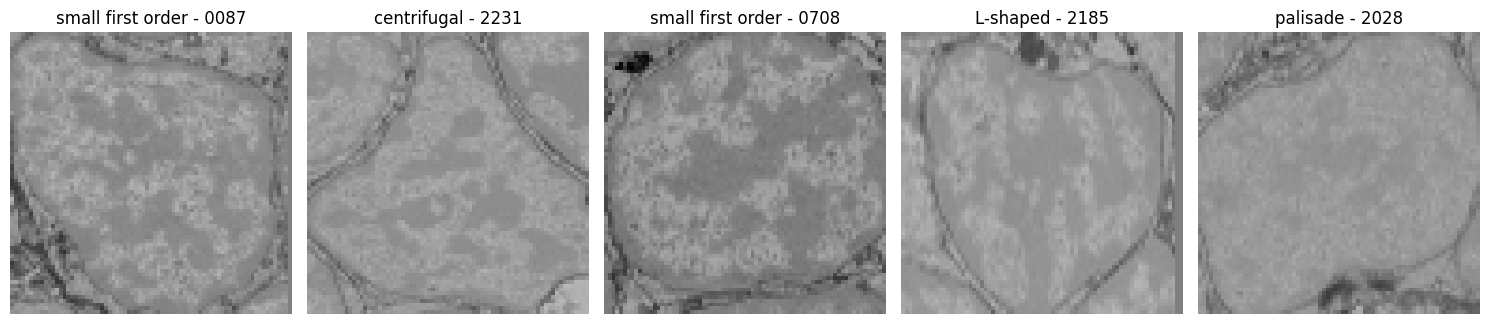

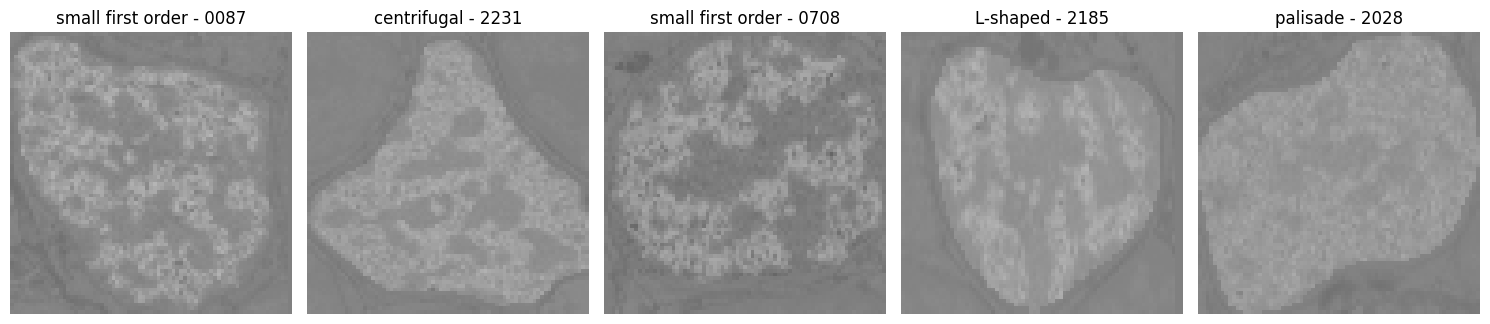

In [ ]:
import os
import glob
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions stay as the original image.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are gray with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        # Create the mask alpha, where 0 is transparency and 1 is full opacity for mask (unmasked regions should show the raw image)
        mask_alpha = (mask_image == 0) * self.transparency  # Transparency applied to unmasked regions

        # Create the blended image
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant', constant_values=128)
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant', constant_values=0)
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data


# Example usage of the class

dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=None, transparency=1.0)
dataset2 = ChromatinDataset(root_dir='/content/chromatin_task', transform=None, transparency=0)
dataset3 = ChromatinDataset(root_dir='/content/chromatin_task', transform=None, transparency=0.8)
random_indices = random.sample(range(len(dataset)),5)
def show_random_samples(dataset, num_samples=5):
    # Select random indices from the dataset

    # Set up the plot grid
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    axes = axes.flatten()

    # Loop through the random samples and display their overlaid images
    for i, idx in enumerate(random_indices):
        sample_data = dataset[idx]
        overlaid_image = sample_data['overlaid_cube']

        # Convert the tensor to a numpy array for plotting
        overlaid_image = overlaid_image.permute(1, 2, 3, 0).numpy()  # Convert (C, H, W, D) to (H, W, D, C)
        overlaid_image = overlaid_image[:, :, overlaid_image.shape[2] // 2, :]  # Take the middle slice

        # Normalize the image to be in the range [0, 1] for floats or [0, 255] for integers
        if overlaid_image.max() > 1:  # Check if it's outside [0, 1]
            overlaid_image = np.clip(overlaid_image, 0, 255)  # Clipping values outside [0, 255]
            overlaid_image = overlaid_image.astype(np.uint8)  # Convert to uint8 for proper visualization
        else:
            overlaid_image = np.clip(overlaid_image, 0, 1)  # Normalize to [0, 1] if it is float
            overlaid_image = (overlaid_image * 255).astype(np.uint8)  # Convert to [0, 255] range for display

        # Show the image on the subplot
        axes[i].imshow(overlaid_image)
        axes[i].set_title(f"{sample_data['cell_type']} - {sample_data['sample']}")
        axes[i].axis('off')  # Hide axes for a cleaner display

    plt.tight_layout()
    plt.show()

# Usage:
show_random_samples(dataset, num_samples=5)
show_random_samples(dataset2, num_samples=5)
show_random_samples(dataset3, num_samples=5)


## Size

In [ ]:
import os
import glob
from PIL import Image
from collections import defaultdict

def analyze_raw_images(root_dir):
    cell_type_sizes = defaultdict(list)
    all_widths = []
    all_heights = []
    min_width = float('inf')
    max_width = float('-inf')
    min_height = float('inf')
    max_height = float('-inf')

    # Iterate through each cell type directory
    for cell_type in sorted(os.listdir(root_dir)):
        cell_type_dir = os.path.join(root_dir, cell_type)

        if os.path.isdir(cell_type_dir):
            # Iterate through each sample directory
            sample_dirs = sorted(os.listdir(cell_type_dir))
            for sample in sample_dirs:
                raw_dir = os.path.join(cell_type_dir, sample, 'raw')

                # Get all .tif files in the raw directory
                raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))

                # Process each raw image
                for raw_file in raw_files:
                    with Image.open(raw_file) as img:
                        width, height = img.size

                        # Collect sizes by cell type
                        cell_type_sizes[cell_type].append((width, height))

                        # Update global min and max dimensions
                        all_widths.append(width)
                        all_heights.append(height)
                        min_width = min(min_width, width)
                        max_width = max(max_width, width)
                        min_height = min(min_height, height)
                        max_height = max(max_height, height)

    # Calculate average width and height across all images
    avg_width = sum(all_widths) / len(all_widths) if all_widths else 0
    avg_height = sum(all_heights) / len(all_heights) if all_heights else 0

    # Calculate unique sizes per cell type
    unique_sizes_by_cell_type = {cell_type: set(cell_type_sizes[cell_type]) for cell_type in cell_type_sizes}

    return avg_width, avg_height, min_width, max_width, min_height, max_height, unique_sizes_by_cell_type

# Specify the path to your dataset
root_dir = '/content/chromatin_task'  # Replace with your dataset path

# Analyze raw image sizes
avg_width, avg_height, min_width, max_width, min_height, max_height, unique_sizes_by_cell_type = analyze_raw_images(root_dir)

print(f"Average Resolution of Raw Images - Width: {avg_width}, Height: {avg_height}")
print(f"Min Width: {min_width}, Max Width: {max_width}")
print(f"Min Height: {min_height}, Max Height: {max_height}")
print("\nUnique Sizes by Cell Type:")
for cell_type, sizes in unique_sizes_by_cell_type.items():
    print(f"{cell_type}: {sizes}")


Average Resolution of Raw Images - Width: 72.38105165624276, Height: 73.55306926106093
Min Width: 23, Max Width: 119
Min Height: 34, Max Height: 116

Unique Sizes by Cell Type:
Glia: {(95, 68)}
L-shaped: {(72, 73), (59, 55), (64, 69), (55, 66), (62, 72), (67, 68), (62, 81), (70, 64), (55, 75), (65, 52), (76, 52), (59, 82), (79, 60), (82, 56), (76, 70), (71, 56), (66, 69), (76, 79), (63, 61), (68, 84), (80, 67), (55, 77), (56, 76), (85, 57), (85, 66), (75, 65), (65, 72), (76, 72), (73, 67), (69, 60), (70, 59), (70, 68), (54, 81), (66, 64), (58, 81), (95, 54), (72, 70), (68, 72), (66, 84), (54, 67), (71, 83), (64, 77), (54, 76), (56, 73), (76, 51), (75, 71), (66, 68), (81, 50), (70, 84), (50, 81), (75, 80), (66, 77), (62, 64), (65, 81), (71, 85), (77, 64), (62, 91), (75, 55), (69, 78), (61, 74), (79, 55), (60, 84), (66, 70), (61, 83), (79, 64), (81, 61), (73, 57), (79, 73), (54, 53), (62, 75), (63, 74), (58, 62), (67, 74), (80, 71), (75, 57), (62, 59), (65, 76), (71, 71), (73, 68), (77, 

 # Performance using t-SNE and UMAP main chckpnt alpha=0.5

In this notebook, we evaluate the performance of **t-SNE** and **UMAP** using several statistical metrics. These techniques are often used for reducing the dimensionality of high-dimensional data and visualizing it in 2D or 3D. To assess their effectiveness, we compare the clustering results to the true class labels (`cell_type`) provided in the dataset.

## Metrics Used for Performance Evaluation

### 1. **Cluster Purity**
Cluster purity measures how well the samples from the same class (label) are grouped together within the same cluster. It is a simple and intuitive measure of clustering quality. A higher purity value indicates that most of the samples within each cluster belong to the same class.

#### Calculation:
For each cluster, we find the most common class label in that cluster and calculate how many points in that cluster have this class label. The overall cluster purity is the ratio of correctly assigned points to the total number of points.

#### Formula:
\[
\text{Cluster Purity} = \frac{\text{Number of correctly assigned points}}{\text{Total number of points}}
\]

### 2. **Silhouette Score**
The **Silhouette Score** is a measure of how similar each point is to its own cluster (cohesion) compared to other clusters (separation). A high silhouette score indicates that the points are well-clustered, both internally (with other points in the same cluster) and externally (away from other clusters).

#### Calculation:
For each sample, we calculate the **silhouette coefficient**:
- **a(i)**: The average distance between point `i` and all other points in the same cluster (cohesion).
- **b(i)**: The average distance between point `i` and all points in the nearest cluster (separation).

The silhouette score for a dataset is the average silhouette coefficient across all points.

#### Formula:
\[
\text{Silhouette Score} = \frac{b(i) - a(i)}{\max(a(i), b(i))}
\]

### 3. **Adjusted Rand Index (ARI)**
The **Adjusted Rand Index (ARI)** measures the similarity between two data clusterings (in this case, the clustering results from t-SNE/UMAP and the true labels). ARI adjusts for the chance grouping of samples, making it a more reliable metric than the raw Rand Index. The ARI can take values between -1 and 1:
- **1**: Perfect clustering (the predicted clusters perfectly match the true labels).
- **0**: The clustering is no better than random chance.
- **Negative values**: The clustering is worse than random chance.

#### Calculation:
ARI compares all pairs of samples and evaluates whether they are in the same cluster in both the true labels and predicted clusters. The adjusted Rand Index corrects for random chance by considering the expected value of the Rand Index.

#### Formula:
\[
\text{ARI} = \frac{\text{RI} - \mathbb{E}[\text{RI}]}{\max(\text{RI}) - \mathbb{E}[\text{RI}]}
\]
Where **RI** is the Rand Index, and **\(\mathbb{E}[\text{RI}]\)** is the expected value under random clustering.

---

## Summary of Metrics:
- **Cluster Purity** helps us assess how well the true labels match with the predicted clusters. Higher purity indicates better clustering.
- **Silhouette Score** provides a measure of how well-separated and cohesive the clusters are. Higher silhouette scores indicate more distinct clusters.
- **Adjusted Rand Index (ARI)** gives us an adjusted measure of clustering accuracy, taking into account chance, with a higher ARI indicating better agreement between the true and predicted labels.

These metrics are crucial in evaluating the effectiveness of dimensionality reduction methods like t-SNE and UMAP, especially when comparing them to the true class labels in the dataset.

## Visual Inspection:
In addition to the statistical metrics, we also plot the t-SNE and UMAP results colored by the true labels and the cluster labels. These plots provide a visual inspection of how well the dimensionality reduction techniques preserve the true groupings of the data.

---

## Results:
The performance evaluation will include the following metrics for both t-SNE and UMAP:
- Cluster Purity
- Silhouette Score
- Adjusted Rand Index (ARI)

You will be able to interpret the results to understand which dimensionality reduction technique (t-SNE or UMAP) provides the best clustering performance for your dataset.

---

## Conclusion:
These statistical methods provide both quantitative and qualitative insights into the effectiveness of t-SNE and UMAP in capturing the underlying structure of the data. Based on the metrics, you can assess which method better preserves the true relationships between samples in a lower-dimensional space.


In [ ]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model):
    # Check if fine_tuned_vgg3d.pth exists

    checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
    checkpoint_path = 'hemibrain_production.checkpoint'

    # Download the fallback checkpoint if not found
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions stay as the original image.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are gray with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        # Create the mask alpha, where 0 is transparency and 1 is full opacity for mask (unmasked regions should show the raw image)
        mask_alpha = (mask_image == 0) * self.transparency  # Transparency applied to unmasked regions

        # Create the blended image
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant', constant_values=128)
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant', constant_values=0)
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def save_to_csv(features, cluster_labels, dataset, model_name, transparency_level, overlay_color):
    # Prepare the DataFrame
    sample_data = []
    for i, (cell_type, sample, raw_files, mask_files) in enumerate(dataset.samples):
        feature_vector = features[i]
        cluster_label = cluster_labels[i]

        # Create a row with cell type, sample, features and cluster label
        row = {
            'cell_type': cell_type,
            'sample': sample,
            'features': feature_vector.tolist(),  # Convert feature vector to list for CSV storage
            'cluster_label': cluster_label
        }
        sample_data.append(row)

    # Create a DataFrame
    df = pd.DataFrame(sample_data)

    # Construct the filename
    file_name = f"{model_name}_{transparency_level}_{overlay_color}.csv"

    # Save to CSV
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

# Initialize dataset and model
dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=None)
full_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model and load pre-trained weights
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
model = load_model_from_checkpoint(model)
model.to(device)
model.eval()

# Extract features
all_features = []
with torch.no_grad():
    for batch in full_dataloader:
        inputs = batch['overlaid_cube'].to(device)
        # Convert RGB to grayscale by averaging channels
        inputs_gray = inputs.mean(dim=1, keepdim=True)  # Shape: [B, 1, H, W, D]
        # Extract features (output from self.features)
        features = model(inputs_gray, return_features=True)
        # Flatten features
        features_flat = features.view(features.size(0), -1)
        all_features.append(features_flat.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)

# Apply KMeans clustering
n_clusters = len(dataset.cell_types)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_features)

# print("Cluster assignments:", cluster_labels)

# Save the data to CSV
model_name = "Vgg3D"  # Replace with the actual model name if needed
transparency_level = dataset.transparency  # This is the transparency level defined in your dataset
overlay_color = "gray"  # This would be the overlay color used, modify if necessary

# Save the data to CSV
save_to_csv(all_features, cluster_labels, dataset, model_name, transparency_level, overlay_color)
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap
import plotly.express as px
from sklearn.metrics import silhouette_score, adjusted_rand_score
import ast

# Load your CSV
df = pd.read_csv('/content/Vgg3D_0.5_gray.csv')

# Convert 'features' from string to actual list using ast.literal_eval
df['features'] = df['features'].apply(ast.literal_eval)

# Convert 'features' from list to a numpy array of shape (n_samples, n_features)
features_array = np.array(df['features'].to_list())

# Define the dimensionality reduction functions
def perform_tsne(features):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(features)

def perform_umap(features):
    reducer = umap.UMAP(n_components=2, random_state=42)
    return reducer.fit_transform(features)

# Perform dimensionality reduction using t-SNE and UMAP
X_tsne = perform_tsne(features_array)
X_umap = perform_umap(features_array)

# Add the results back to the dataframe
df['tsne_1'], df['tsne_2'] = X_tsne[:, 0], X_tsne[:, 1]
df['umap_1'], df['umap_2'] = X_umap[:, 0], X_umap[:, 1]

# --- Statistical Performance Evaluation ---

# 1. Cluster Purity (for t-SNE and UMAP)
def calculate_cluster_purity(true_labels, cluster_labels):
    correct = 0
    total = len(true_labels)
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_true_labels = true_labels[cluster_indices]
        most_common_label = np.bincount(cluster_true_labels).argmax()
        correct += (cluster_true_labels == most_common_label).sum()
    return correct / total

# Convert categorical labels to numeric
df['true_labels'] = pd.factorize(df['cell_type'])[0]
df['tsne_cluster_label'] = pd.factorize(df['cluster_label'])[0]
df['umap_cluster_label'] = pd.factorize(df['cluster_label'])[0]

tsne_purity = calculate_cluster_purity(df['true_labels'], df['tsne_cluster_label'])
umap_purity = calculate_cluster_purity(df['true_labels'], df['umap_cluster_label'])

# 2. Silhouette Score (for t-SNE and UMAP)
tsne_silhouette = silhouette_score(X_tsne, df['tsne_cluster_label'])
umap_silhouette = silhouette_score(X_umap, df['umap_cluster_label'])

# 3. Adjusted Rand Index (ARI) (for t-SNE and UMAP)
tsne_ari = adjusted_rand_score(df['true_labels'], df['tsne_cluster_label'])
umap_ari = adjusted_rand_score(df['true_labels'], df['umap_cluster_label'])

# --- Display Results ---
# Organize the results into a dictionary
results = {
    "t-SNE Purity": tsne_purity,
    "UMAP Purity": umap_purity,
    "t-SNE Silhouette Score": tsne_silhouette,
    "UMAP Silhouette Score": umap_silhouette,
    "t-SNE ARI": tsne_ari,
    "UMAP ARI": umap_ari
}

# Display results in a readable format
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Create the plot for t-SNE based on true labels
fig_tsne_truth = px.scatter(df, x='tsne_1', y='tsne_2', color='cell_type',
                            title="t-SNE based on True Labels", labels={'cell_type': 'Cell Type'})

# Display the plots with square dimensions
fig_tsne_truth.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)
# Create the plot for t-SNE based on cluster labels
fig_tsne_cluster = px.scatter(df, x='tsne_1', y='tsne_2', color='cluster_label',
                              title="t-SNE based on Cluster Labels", labels={'cluster_label': 'Cluster Label'})
fig_tsne_cluster.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Create the plot for UMAP based on true labels
fig_umap_truth = px.scatter(df, x='umap_1', y='umap_2', color='cell_type',
                            title="UMAP based on True Labels", labels={'cell_type': 'Cell Type'})

fig_umap_truth.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Create the plot for UMAP based on cluster labels
fig_umap_cluster = px.scatter(df, x='umap_1', y='umap_2', color='cluster_label',
                              title="UMAP based on Cluster Labels", labels={'cluster_label': 'Cluster Label'})
fig_umap_cluster.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Show all the plots
fig_tsne_truth.show()
fig_tsne_cluster.show()
fig_umap_truth.show()
fig_umap_cluster.show()


fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-19-a09ffff4cd3f>:30: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Data saved to Vgg3D_1.0_gray.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



t-SNE Purity: 0.3831
UMAP Purity: 0.3831
t-SNE Silhouette Score: 0.0862
UMAP Silhouette Score: -0.0070
t-SNE ARI: 0.0725
UMAP ARI: 0.0725


# with finetuned Version

In [ ]:
!cp /content/drive/MyDrive/fine_tuned_vgg3d_with_mask_overlaid.pth /content

In [ ]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions stay as the original image.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are gray with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        # Create the mask alpha, where 0 is transparency and 1 is full opacity for mask (unmasked regions should show the raw image)
        mask_alpha = (mask_image == 0) * self.transparency  # Transparency applied to unmasked regions

        # Create the blended image
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant', constant_values=128)
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant', constant_values=0)
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def save_to_csv(features, cluster_labels, dataset, model_name, transparency_level, overlay_color):
    # Prepare the DataFrame
    sample_data = []
    for i, (cell_type, sample, raw_files, mask_files) in enumerate(dataset.samples):
        feature_vector = features[i]
        cluster_label = cluster_labels[i]

        # Create a row with cell type, sample, features and cluster label
        row = {
            'cell_type': cell_type,
            'sample': sample,
            'features': feature_vector.tolist(),  # Convert feature vector to list for CSV storage
            'cluster_label': cluster_label
        }
        sample_data.append(row)

    # Create a DataFrame
    df = pd.DataFrame(sample_data)

    # Construct the filename
    file_name = f"{model_name}_{transparency_level}_{overlay_color}.csv"

    # Save to CSV
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

# Initialize dataset and model
dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=None)
full_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model and load pre-trained weights
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
model = load_model_from_checkpoint(model,'/content/fine_tuned_vgg3d_with_mask_overlaid.pth')
model.to(device)
model.eval()

# Extract features
all_features = []
with torch.no_grad():
    for batch in full_dataloader:
        inputs = batch['overlaid_cube'].to(device)
        # Convert RGB to grayscale by averaging channels
        inputs_gray = inputs.mean(dim=1, keepdim=True)  # Shape: [B, 1, H, W, D]
        # Extract features (output from self.features)
        features = model(inputs_gray, return_features=True)
        # Flatten features
        features_flat = features.view(features.size(0), -1)
        all_features.append(features_flat.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)

# Apply KMeans clustering
n_clusters = len(dataset.cell_types)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_features)

# print("Cluster assignments:", cluster_labels)

# Save the data to CSV
model_name = "Vgg3D"  # Replace with the actual model name if needed
transparency_level = dataset.transparency  # This is the transparency level defined in your dataset
overlay_color = "gray"  # This would be the overlay color used, modify if necessary

# Save the data to CSV
save_to_csv(all_features, cluster_labels, dataset, model_name, transparency_level, overlay_color)
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap
import plotly.express as px
from sklearn.metrics import silhouette_score, adjusted_rand_score
import ast

# Load your CSV
df = pd.read_csv('/content/Vgg3D_1.0_gray.csv')

# Convert 'features' from string to actual list using ast.literal_eval
df['features'] = df['features'].apply(ast.literal_eval)

# Convert 'features' from list to a numpy array of shape (n_samples, n_features)
features_array = np.array(df['features'].to_list())

# Define the dimensionality reduction functions
def perform_tsne(features):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(features)

def perform_umap(features):
    reducer = umap.UMAP(n_components=2, random_state=42)
    return reducer.fit_transform(features)

# Perform dimensionality reduction using t-SNE and UMAP
X_tsne = perform_tsne(features_array)
X_umap = perform_umap(features_array)

# Add the results back to the dataframe
df['tsne_1'], df['tsne_2'] = X_tsne[:, 0], X_tsne[:, 1]
df['umap_1'], df['umap_2'] = X_umap[:, 0], X_umap[:, 1]

# --- Statistical Performance Evaluation ---

# 1. Cluster Purity (for t-SNE and UMAP)
def calculate_cluster_purity(true_labels, cluster_labels):
    correct = 0
    total = len(true_labels)
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_true_labels = true_labels[cluster_indices]
        most_common_label = np.bincount(cluster_true_labels).argmax()
        correct += (cluster_true_labels == most_common_label).sum()
    return correct / total

# Convert categorical labels to numeric
df['true_labels'] = pd.factorize(df['cell_type'])[0]
df['tsne_cluster_label'] = pd.factorize(df['cluster_label'])[0]
df['umap_cluster_label'] = pd.factorize(df['cluster_label'])[0]

tsne_purity = calculate_cluster_purity(df['true_labels'], df['tsne_cluster_label'])
umap_purity = calculate_cluster_purity(df['true_labels'], df['umap_cluster_label'])

# 2. Silhouette Score (for t-SNE and UMAP)
tsne_silhouette = silhouette_score(X_tsne, df['tsne_cluster_label'])
umap_silhouette = silhouette_score(X_umap, df['umap_cluster_label'])

# 3. Adjusted Rand Index (ARI) (for t-SNE and UMAP)
tsne_ari = adjusted_rand_score(df['true_labels'], df['tsne_cluster_label'])
umap_ari = adjusted_rand_score(df['true_labels'], df['umap_cluster_label'])

# --- Display Results ---
# Organize the results into a dictionary
results = {
    "t-SNE Purity": tsne_purity,
    "UMAP Purity": umap_purity,
    "t-SNE Silhouette Score": tsne_silhouette,
    "UMAP Silhouette Score": umap_silhouette,
    "t-SNE ARI": tsne_ari,
    "UMAP ARI": umap_ari
}

# Display results in a readable format
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Create the plot for t-SNE based on true labels
fig_tsne_truth = px.scatter(df, x='tsne_1', y='tsne_2', color='cell_type',
                            title="t-SNE based on True Labels", labels={'cell_type': 'Cell Type'})

# Display the plots with square dimensions
fig_tsne_truth.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)
# Create the plot for t-SNE based on cluster labels
fig_tsne_cluster = px.scatter(df, x='tsne_1', y='tsne_2', color='cluster_label',
                              title="t-SNE based on Cluster Labels", labels={'cluster_label': 'Cluster Label'})
fig_tsne_cluster.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Create the plot for UMAP based on true labels
fig_umap_truth = px.scatter(df, x='umap_1', y='umap_2', color='cell_type',
                            title="UMAP based on True Labels", labels={'cell_type': 'Cell Type'})

fig_umap_truth.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Create the plot for UMAP based on cluster labels
fig_umap_cluster = px.scatter(df, x='umap_1', y='umap_2', color='cluster_label',
                              title="UMAP based on Cluster Labels", labels={'cluster_label': 'Cluster Label'})
fig_umap_cluster.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Show all the plots
fig_tsne_truth.show()
fig_tsne_cluster.show()
fig_umap_truth.show()
fig_umap_cluster.show()


Loading model from fine_tuned_vgg3d.pth...


<ipython-input-22-f7e3a8cc6eb2>:33: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Data saved to Vgg3D_1.0_gray.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



t-SNE Purity: 0.4842
UMAP Purity: 0.4842
t-SNE Silhouette Score: 0.2009
UMAP Silhouette Score: 0.2762
t-SNE ARI: 0.1540
UMAP ARI: 0.1540


## Finetuned 0.5

In [ ]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions stay as the original image.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are gray with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        # Create the mask alpha, where 0 is transparency and 1 is full opacity for mask (unmasked regions should show the raw image)
        mask_alpha = (mask_image == 0) * self.transparency  # Transparency applied to unmasked regions

        # Create the blended image
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant', constant_values=128)
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant', constant_values=0)
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def save_to_csv(features, cluster_labels, dataset, model_name, transparency_level, overlay_color):
    # Prepare the DataFrame
    sample_data = []
    for i, (cell_type, sample, raw_files, mask_files) in enumerate(dataset.samples):
        feature_vector = features[i]
        cluster_label = cluster_labels[i]

        # Create a row with cell type, sample, features and cluster label
        row = {
            'cell_type': cell_type,
            'sample': sample,
            'features': feature_vector.tolist(),  # Convert feature vector to list for CSV storage
            'cluster_label': cluster_label
        }
        sample_data.append(row)

    # Create a DataFrame
    df = pd.DataFrame(sample_data)

    # Construct the filename
    file_name = f"{model_name}_{transparency_level}_{overlay_color}.csv"

    # Save to CSV
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

# Initialize dataset and model
dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=None)
full_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model and load pre-trained weights
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
model = load_model_from_checkpoint(model,'/content/fine_tuned_vgg3d_with_mask_overlaid.pth')
model.to(device)
model.eval()

# Extract features
all_features = []
with torch.no_grad():
    for batch in full_dataloader:
        inputs = batch['overlaid_cube'].to(device)
        # Convert RGB to grayscale by averaging channels
        inputs_gray = inputs.mean(dim=1, keepdim=True)  # Shape: [B, 1, H, W, D]
        # Extract features (output from self.features)
        features = model(inputs_gray, return_features=True)
        # Flatten features
        features_flat = features.view(features.size(0), -1)
        all_features.append(features_flat.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)

# Apply KMeans clustering
n_clusters = len(dataset.cell_types)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_features)

# print("Cluster assignments:", cluster_labels)

# Save the data to CSV
model_name = "Vgg3D"  # Replace with the actual model name if needed
transparency_level = dataset.transparency  # This is the transparency level defined in your dataset
overlay_color = "gray"  # This would be the overlay color used, modify if necessary

# Save the data to CSV
save_to_csv(all_features, cluster_labels, dataset, model_name, transparency_level, overlay_color)
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap
import plotly.express as px
from sklearn.metrics import silhouette_score, adjusted_rand_score
import ast

# Load your CSV
df = pd.read_csv('/content/Vgg3D_0.5_gray.csv')

# Convert 'features' from string to actual list using ast.literal_eval
df['features'] = df['features'].apply(ast.literal_eval)

# Convert 'features' from list to a numpy array of shape (n_samples, n_features)
features_array = np.array(df['features'].to_list())

# Define the dimensionality reduction functions
def perform_tsne(features):
    tsne = TSNE(n_components=2, random_state=42)
    return tsne.fit_transform(features)

def perform_umap(features):
    reducer = umap.UMAP(n_components=2, random_state=42)
    return reducer.fit_transform(features)

# Perform dimensionality reduction using t-SNE and UMAP
X_tsne = perform_tsne(features_array)
X_umap = perform_umap(features_array)

# Add the results back to the dataframe
df['tsne_1'], df['tsne_2'] = X_tsne[:, 0], X_tsne[:, 1]
df['umap_1'], df['umap_2'] = X_umap[:, 0], X_umap[:, 1]

# --- Statistical Performance Evaluation ---

# 1. Cluster Purity (for t-SNE and UMAP)
def calculate_cluster_purity(true_labels, cluster_labels):
    correct = 0
    total = len(true_labels)
    for cluster in np.unique(cluster_labels):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_true_labels = true_labels[cluster_indices]
        most_common_label = np.bincount(cluster_true_labels).argmax()
        correct += (cluster_true_labels == most_common_label).sum()
    return correct / total

# Convert categorical labels to numeric
df['true_labels'] = pd.factorize(df['cell_type'])[0]
df['tsne_cluster_label'] = pd.factorize(df['cluster_label'])[0]
df['umap_cluster_label'] = pd.factorize(df['cluster_label'])[0]

tsne_purity = calculate_cluster_purity(df['true_labels'], df['tsne_cluster_label'])
umap_purity = calculate_cluster_purity(df['true_labels'], df['umap_cluster_label'])

# 2. Silhouette Score (for t-SNE and UMAP)
tsne_silhouette = silhouette_score(X_tsne, df['tsne_cluster_label'])
umap_silhouette = silhouette_score(X_umap, df['umap_cluster_label'])

# 3. Adjusted Rand Index (ARI) (for t-SNE and UMAP)
tsne_ari = adjusted_rand_score(df['true_labels'], df['tsne_cluster_label'])
umap_ari = adjusted_rand_score(df['true_labels'], df['umap_cluster_label'])

# --- Display Results ---
# Organize the results into a dictionary
results = {
    "t-SNE Purity": tsne_purity,
    "UMAP Purity": umap_purity,
    "t-SNE Silhouette Score": tsne_silhouette,
    "UMAP Silhouette Score": umap_silhouette,
    "t-SNE ARI": tsne_ari,
    "UMAP ARI": umap_ari
}

# Display results in a readable format
for key, value in results.items():
    print(f"{key}: {value:.4f}")

# Create the plot for t-SNE based on true labels
fig_tsne_truth = px.scatter(df, x='tsne_1', y='tsne_2', color='cell_type',
                            title="t-SNE based on True Labels", labels={'cell_type': 'Cell Type'})

# Display the plots with square dimensions
fig_tsne_truth.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)
# Create the plot for t-SNE based on cluster labels
fig_tsne_cluster = px.scatter(df, x='tsne_1', y='tsne_2', color='cluster_label',
                              title="t-SNE based on Cluster Labels", labels={'cluster_label': 'Cluster Label'})
fig_tsne_cluster.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Create the plot for UMAP based on true labels
fig_umap_truth = px.scatter(df, x='umap_1', y='umap_2', color='cell_type',
                            title="UMAP based on True Labels", labels={'cell_type': 'Cell Type'})

fig_umap_truth.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5  # Center title
)

# Create the plot for UMAP based on cluster labels
fig_umap_cluster = px.scatter(df, x='umap_1', y='umap_2', color='cluster_label',
                              title="UMAP based on Cluster Labels", labels={'cluster_label': 'Cluster Label'})
fig_umap_cluster.update_layout(
    autosize=False,
    width=1000,
    height=600,
    title_x=0.5
)

# Show all the plots
fig_tsne_truth.show()
fig_tsne_cluster.show()
fig_umap_truth.show()
fig_umap_cluster.show()


Loading model from fine_tuned_vgg3d.pth...


<ipython-input-23-da751bcc35cf>:33: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Data saved to Vgg3D_0.5_gray.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



t-SNE Purity: 0.4710
UMAP Purity: 0.4710
t-SNE Silhouette Score: 0.2930
UMAP Silhouette Score: 0.3487
t-SNE ARI: 0.1642
UMAP ARI: 0.1642


In [ ]:
# prompt: write this dfs head  /content/Vgg3D_0.5_gray.csv

import pandas as pd

# Load the first 5 lines of the CSV file
df_head = pd.read_csv('/content/Vgg3D_0.5_gray.csv', nrows=5)

# Display the head of the DataFrame
df_head


,cell_type,sample,features,cluster_label
0,L-shaped,1515,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
1,L-shaped,1543,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
2,L-shaped,1594,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
3,L-shaped,1635,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11
4,L-shaped,1759,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9


# Try

## VGG Clustering (without finetuning)

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )


    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return features for saving
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Initialize model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)

# Load the pretrained model
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# Move model to device
model.to(device)

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Extract features and save them to CSV
output_csv = "features.csv"
extract_features_and_save(model, dataloader, output_csv)
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Load features from the CSV
df = pd.read_csv('features.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
# Plot 2D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="t-SNE Visualization of Clusters with VGG without finetuning",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_clusters.show()
# Plot 2D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="t-SNE Visualization of True Classes with VGG without finetuning",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_classes.show()


Loading model from fine_tuned_vgg3d.pth...


<ipython-input-30-3d7795b3544b>:32: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Features saved to features.csv


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Load features from the CSV
df = pd.read_csv('features.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
# Plot 2D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="t-SNE Visualization of Clusters",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_clusters.show()
# Plot 2D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="t-SNE Visualization of True Classes",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_classes.show()


## VGG Clustering with finetuned version

In [ ]:
! cp /content/drive/MyDrive/fine_tuned_vgg3d_with_mask_overlaid.pth /content/fine_tuned_vgg3d.pth

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")
augmentation_transforms = transforms.Compose([])

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D model class remains the same
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        # Validate input parameters
        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]

            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]

            layers.append(nn.MaxPool3d(df))

            current_fmaps = fmaps
            fmaps *= fmap_inc[i]

            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier layer (will be reinitialized later)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),  # This will be adapted to your dataset
        )


    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return features for saving
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Initialize model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)

# Load the pretrained model
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# Move model to device
model.to(device)

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Extract features and save them to CSV
output_csv = "featureswithalpha_1.csv"
extract_features_and_save(model, dataloader, output_csv)

Loading model from fine_tuned_vgg3d.pth...


<ipython-input-12-1aa0819e5133>:197: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Features saved to featureswithalpha_1.csv


In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=1.0):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:  # Simply iterate over the dataloader without enumerate
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)

            inputs = inputs.squeeze(2)  # Adjust dimensions
            targets = targets.to(device)

            # Extract features from the model
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()  # Flatten features

            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    # Convert the list of features and labels into numpy arrays
    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    # Create a DataFrame for features and labels
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array

    # Save to CSV
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")
augmentation_transforms = transforms.Compose([])

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Initialize model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)

# Load the pretrained model
fine_tuned_path = 'fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, fine_tuned_path)

# Move model to device
model.to(device)

# Custom dataset class
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75),transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        # self.mask_policy = mask_policy  # 'masked' or 'unmasked'
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}  # Map cell types to integer labels
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0  # RGB channels set to black (0)

        # if self.mask_policy == "masked":
        #     mask_alpha = (mask_image > 0) * self.transparency
        # elif self.mask_policy == "unmasked":
        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use black with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image
    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        # Overlay mask on raw data for the whole cube (depth slices)
        # overlaid_cube = np.zeros((raw_data.shape[0], raw_data.shape[1], raw_data.shape[2], 3), dtype=np.uint8)  # RGB cube

        # Initialize overlaid_cube with correct dimensions (H, W, D, 3)
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    # Convert RGB to grayscale using the formula: Y = 0.2989 * R + 0.5870 * G + 0.1140 * B
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Add channel dimension
# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task',transform=augmentation_transforms)

# Data Augmentation for balancing classes
augmentation_transforms = transforms.Compose([])
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Extract features and save them to CSV
output_csv = "featureswithalpha_1.csv"
extract_features_and_save(model, dataloader, output_csv)

In [ ]:

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
# Plot 2D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="t-SNE Visualization of Clusters",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,
)

fig_clusters.show()
# Plot 2D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="t-SNE Visualization of True Classes",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2",
    showlegend=True,)

fig_classes.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply t-SNE for dimensionality reduction to 3D
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(features)

# Add t-SNE results to the dataframe
df['tsne_1'] = tsne_results[:, 0]
df['tsne_2'] = tsne_results[:, 1]
df['tsne_3'] = tsne_results[:, 2]

# Plot 3D t-SNE with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter3d(
        x=cluster_data['tsne_1'],
        y=cluster_data['tsne_2'],
        z=cluster_data['tsne_3'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=2, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="3D t-SNE Visualization of Clusters",
    scene=dict(
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        zaxis_title="t-SNE Component 3"
    ),
    showlegend=True,
)

fig_clusters.show()

# Plot 3D t-SNE with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter3d(
        x=class_data['tsne_1'],
        y=class_data['tsne_2'],
        z=class_data['tsne_3'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=2, opacity=0.8),
    ))

fig_classes.update_layout(
    title="3D t-SNE Visualization of True Classes",
    scene=dict(
        xaxis_title="t-SNE Component 1",
        yaxis_title="t-SNE Component 2",
        zaxis_title="t-SNE Component 3"
    ),
    showlegend=True,
)

fig_classes.show()


In [ ]:
pip install umap-learn


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd

import numpy as np

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd

import numpy as np

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjusted Rand Index (ARI) score: 0.15488834020267034


Adjusted Rand Index (ARI) score: 0.15488834020267034


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, fowlkes_mallows_score

# Calculate clustering evaluation metrics

# 1. Adjusted Rand Index (ARI)
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# 2. Homogeneity, Completeness, and V-Measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, df['cluster'])
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")

# 3. Silhouette Score
silhouette_avg = silhouette_score(features, df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# 4. Mutual Information (MI)
mi_score = mutual_info_score(labels, df['cluster'])
print(f"Mutual Information: {mi_score}")

# 5. Fowlkes-Mallows Index (FMI)
fmi_score = fowlkes_mallows_score(labels, df['cluster'])
print(f"Fowlkes-Mallows Index: {fmi_score}")



Adjusted Rand Index (ARI) score: 0.15488834020267034
Homogeneity: 0.4134712781936444
Completeness: 0.3515861355846947
V-Measure: 0.3800257765163913
Silhouette Score: 0.03508567621865537
Mutual Information: 0.9735284273789028
Fowlkes-Mallows Index: 0.24334304668966375


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjusted Rand Index (ARI) score: 0.15488834020267034
Homogeneity: 0.4134712781936444
Completeness: 0.3515861355846947
V-Measure: 0.3800257765163913
Silhouette Score: 0.03508567621865537
Mutual Information: 0.9735284273789028
Fowlkes-Mallows Index: 0.24334304668966375


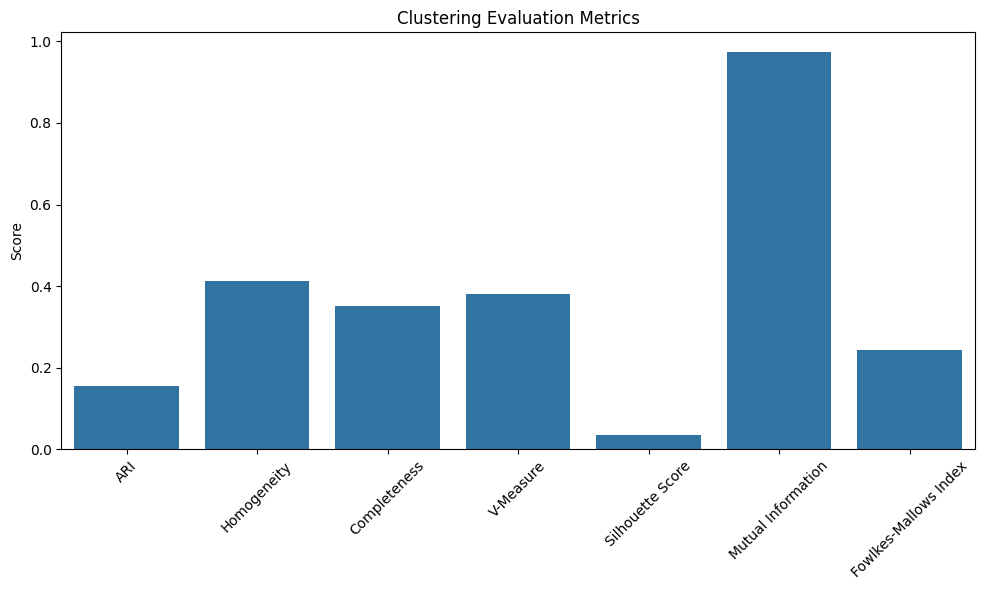

<ipython-input-18-08a2d75275b9>:68: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




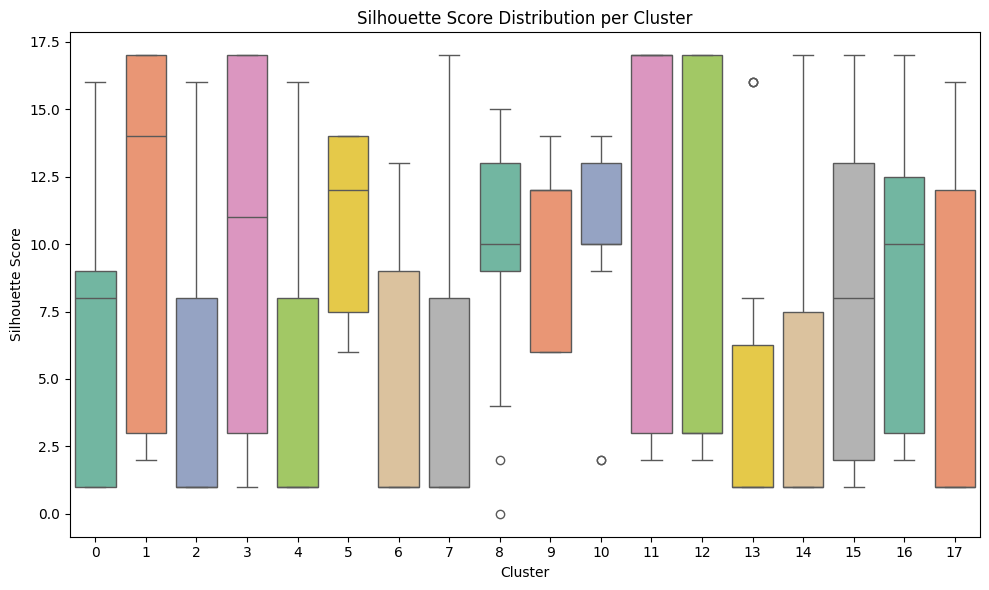

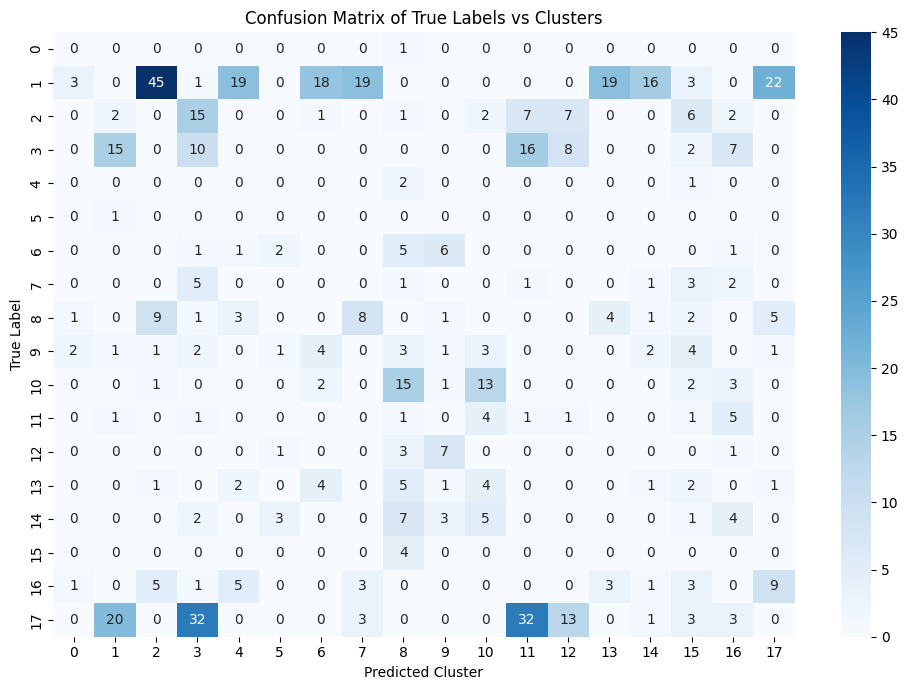

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import umap
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, fowlkes_mallows_score

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate clustering evaluation metrics
ari_score = adjusted_rand_score(labels, df['cluster'])
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, df['cluster'])
silhouette_avg = silhouette_score(features, df['cluster'])
mi_score = mutual_info_score(labels, df['cluster'])
fmi_score = fowlkes_mallows_score(labels, df['cluster'])

# Print the evaluation metrics
print(f"Adjusted Rand Index (ARI) score: {ari_score}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Mutual Information: {mi_score}")
print(f"Fowlkes-Mallows Index: {fmi_score}")

# Create a dictionary for the metrics
metrics = {
    'ARI': ari_score,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-Measure': v_measure,
    'Silhouette Score': silhouette_avg,
    'Mutual Information': mi_score,
    'Fowlkes-Mallows Index': fmi_score
}

# Create a bar plot for the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title("Clustering Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For a more detailed look at the Silhouette Score, you can use a boxplot
# If you want to visualize the distribution of the silhouette score across the samples:
silhouette_vals = silhouette_score(features, df['cluster'], sample_size=len(df), metric='euclidean')
plt.figure(figsize=(10, 6))
sns.boxplot(y=labels, x=df['cluster'], palette='Set2')
plt.title("Silhouette Score Distribution per Cluster")
plt.ylabel("Silhouette Score")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

# Optional: Create a heatmap for the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, df['cluster'])

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix of True Labels vs Clusters")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, homogeneity_completeness_v_measure, silhouette_score, mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import confusion_matrix

# Load features from the CSV
df = pd.read_csv('featureswithalpha_1.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply GMM clustering with 18 components (clusters)
gmm = GaussianMixture(n_components=18, random_state=42)
df['cluster'] = gmm.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate clustering evaluation metrics
ari_score = adjusted_rand_score(labels, df['cluster'])
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, df['cluster'])
silhouette_avg = silhouette_score(features, df['cluster'])
mi_score = mutual_info_score(labels, df['cluster'])
fmi_score = fowlkes_mallows_score(labels, df['cluster'])

# Print the evaluation metrics
print(f"Adjusted Rand Index (ARI) score: {ari_score}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-Measure: {v_measure}")
print(f"Silhouette Score: {silhouette_avg}")
print(f"Mutual Information: {mi_score}")
print(f"Fowlkes-Mallows Index: {fmi_score}")

# Create a dictionary for the metrics
metrics = {
    'ARI': ari_score,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-Measure': v_measure,
    'Silhouette Score': silhouette_avg,
    'Mutual Information': mi_score,
    'Fowlkes-Mallows Index': fmi_score
}

# Create a bar plot for the metrics
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title("Clustering Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For a more detailed look at the Silhouette Score, you can use a boxplot
# If you want to visualize the distribution of the silhouette score across the samples:
silhouette_vals = silhouette_score(features, df['cluster'], sample_size=len(df), metric='euclidean')
plt.figure(figsize=(10, 6))
sns.boxplot(y=labels, x=df['cluster'], palette='Set2')
plt.title("Silhouette Score Distribution per Cluster")
plt.ylabel("Silhouette Score")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

# Optional: Create a heatmap for the confusion matrix
# Compute confusion matrix
conf_matrix = confusion_matrix(labels, df['cluster'])

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title("Confusion Matrix of True Labels vs Clusters")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()


Train on clustering instead of classification

## VGG Edited alpha=1

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model
# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# def load_model_from_checkpoint(model, checkpoint_path):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.eval()
#     return model

# Custom dataset class for chromatin images
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=0.8):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))
        self.transparency = transparency
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))
        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))
        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0
        mask_alpha = (mask_image == 0) * self.transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]
            mask_data = mask_data[:, :, :self.target_size[2]]

        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)

        target = self.cell_type_to_idx[cell_type]
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):
            raw_slice = raw_data[:, :, i].numpy().squeeze()
            mask_slice = mask_data[:, :, i].numpy().squeeze()
            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))
            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)

        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)
        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)

def extract_features_and_save(model, dataloader, output_csv):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)
            inputs = inputs.squeeze(2)
            targets = targets.to(device)
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()
            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)
    feature_columns = [f"feature_{i}" for i in range(features_array.shape[1])]
    df_features = pd.DataFrame(features_array, columns=feature_columns)
    df_features['label'] = labels_array
    df_features.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")

# Define paths
dataset = ChromatinDataset(root_dir='/content/chromatin_task')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Load model from checkpoint
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
checkpoint_path = '/content/fine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, checkpoint_path)
model.to(device)

# Extract features and save them to CSV
output_csv = "fine_tuned_vgg3d_edited.csv"
extract_features_and_save(model, dataloader, output_csv)
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('/content/fine_tuned_vgg3d_edited.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


Loading model from fine_tuned_vgg3d.pth...


<ipython-input-4-27106887b8ad>:32: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Features saved to fine_tuned_vgg3d_edited.csv


In [ ]:
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score

# Load features from the CSV
df = pd.read_csv('/content/fine_tuned_vgg3d_edited.csv')

# Extract the feature columns and labels
features = df.drop(columns=['label']).values  # Features (excluding labels)
labels = df['label'].values  # True class labels

# Apply KMeans clustering with 18 clusters
kmeans = KMeans(n_clusters=18, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(features)

# Add UMAP results to the dataframe
df['umap_1'] = umap_results[:, 0]
df['umap_2'] = umap_results[:, 1]

# Calculate the adjusted Rand index (ARI) between true labels and predicted clusters
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

# Plot 2D UMAP with clusters
fig_clusters = go.Figure()

# Create a scatter plot for each cluster
for cluster in range(18):
    cluster_data = df[df['cluster'] == cluster]
    fig_clusters.add_trace(go.Scatter(
        x=cluster_data['umap_1'],
        y=cluster_data['umap_2'],
        mode='markers',
        name=f'Cluster {cluster}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_clusters.update_layout(
    title="UMAP Visualization of Clusters",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_clusters.show()

# Plot 2D UMAP with true classes
fig_classes = go.Figure()

# Create a scatter plot for each class
for class_label in np.unique(labels):
    class_data = df[df['label'] == class_label]
    fig_classes.add_trace(go.Scatter(
        x=class_data['umap_1'],
        y=class_data['umap_2'],
        mode='markers',
        name=f'Class {class_label}',
        marker=dict(size=6, opacity=0.8),
    ))

fig_classes.update_layout(
    title="UMAP Visualization of True Classes",
    xaxis_title="UMAP Component 1",
    yaxis_title="UMAP Component 2",
    showlegend=True,
)

fig_classes.show()
ari_score = adjusted_rand_score(labels, df['cluster'])
print(f"Adjusted Rand Index (ARI) score: {ari_score}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Adjusted Rand Index (ARI) score: 0.11822039922515458


Adjusted Rand Index (ARI) score: 0.11822039922515458


## Train with Clustering

In [ ]:
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
import umap
from sklearn.metrics import adjusted_rand_score

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model, fine_tuned_path):
    # Check if fine_tuned_vgg3d.pth exists
    if os.path.exists(fine_tuned_path):
        print("Loading model from fine_tuned_vgg3d.pth...")
        checkpoint_path = fine_tuned_path
    else:
        checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
        checkpoint_path = 'hemibrain_production.checkpoint'

        # Download the fallback checkpoint if not found
        os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
        print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Custom dataset class for chromatin images
class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=1):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))
        self.transparency = transparency
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))
        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))
        black_image = np.zeros_like(raw_image)
        black_image[:, :, 0:3] = 0
        mask_alpha = (mask_image == 0) * self.transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * black_image
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]
            mask_data = mask_data[:, :, :self.target_size[2]]

        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)

        target = self.cell_type_to_idx[cell_type]
        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):
            raw_slice = raw_data[:, :, i].numpy().squeeze()
            mask_slice = mask_data[:, :, i].numpy().squeeze()
            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))
            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)

        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)
        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def rgb_to_grayscale(tensor):
    r, g, b = tensor[:, 0, :, :, :], tensor[:, 1, :, :, :], tensor[:, 2, :, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)
import torch
import os
import glob
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.optim as optim
from PIL import Image
from sklearn.cluster import KMeans
import umap
import plotly.graph_objects as go
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

# Define necessary functions and model here (the same as in the original code)...
# I assume Vgg3D, ChromatinDataset, and the other helper functions are already defined in your script.

# Feature extraction function (same as before)
def extract_features_and_save(model, dataloader):
    features_list = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch['overlaid_cube'].to(device), batch['target'].to(device)
            inputs = rgb_to_grayscale(inputs)
            inputs = inputs.squeeze(2)
            targets = targets.to(device)
            features = model(inputs, return_features=True)
            features = features.view(features.size(0), -1).cpu().numpy()
            features_list.append(features)
            labels_list.append(targets.cpu().numpy())

    features_array = np.concatenate(features_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    return features_array, labels_array

# Load the dataset
dataset = ChromatinDataset(root_dir='/content/chromatin_task')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
checkpoint_path = '/content/trainingfine_tuned_vgg3d.pth'
model = load_model_from_checkpoint(model, checkpoint_path)
model.to(device)

# Extract features from the dataset
features, true_labels = extract_features_and_save(model, dataloader)

# Apply KMeans clustering to the features
num_clusters = 18  # Set the number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features)

# Now treat these cluster labels as pseudo-labels
pseudo_labels = cluster_labels

# Train a new model using the pseudo-labels
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# Define the model and optimizer for training
classifier = SimpleClassifier(input_size=features.shape[1], output_size=num_clusters)
classifier.to(device)

criterion = nn.CrossEntropyLoss()  # Since we treat it as a classification task
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Convert the pseudo labels to tensor
pseudo_labels_tensor = torch.tensor(pseudo_labels, dtype=torch.long).to(device)

# Train the classifier based on the pseudo-labels
def train_classifier(model, features, pseudo_labels, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features)

        # Compute loss
        loss = criterion(outputs, pseudo_labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Train the model
features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
train_classifier(classifier, features_tensor, pseudo_labels_tensor, optimizer, criterion, epochs=10)

# Evaluate the classifier
def evaluate_classifier(model, features, pseudo_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == pseudo_labels).sum().item()
        accuracy = 100 * correct / len(pseudo_labels)
        print(f"Accuracy: {accuracy:.2f}%")

# Evaluate the classifier on the pseudo-labels
evaluate_classifier(classifier, features_tensor, pseudo_labels_tensor)


fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-6-c78e8cb272d0>:35: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Epoch [1/10], Loss: 2.8932
Epoch [2/10], Loss: 2.8577
Epoch [3/10], Loss: 2.8524
Epoch [4/10], Loss: 2.7919
Epoch [5/10], Loss: 2.7842
Epoch [6/10], Loss: 2.7428
Epoch [7/10], Loss: 2.7175
Epoch [8/10], Loss: 2.6833
Epoch [9/10], Loss: 2.6676
Epoch [10/10], Loss: 2.6426
Accuracy: 42.81%


# VGG without FienTune and Ignore classes less than 5 samples alpha=1

In [4]:
import torch
import os
import glob
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from PIL import Image
from sklearn.cluster import KMeans
import pandas as pd

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load the pre-trained model
def load_model_from_checkpoint(model):
    # Check if fine_tuned_vgg3d.pth exists

    checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
    checkpoint_path = 'hemibrain_production.checkpoint'

    # Download the fallback checkpoint if not found
    os.system(f"wget -O {checkpoint_path} '{checkpoint_url}'")
    print("fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Update the model with the state dict from the checkpoint
    model_dict = model.state_dict()
    if 'model_state_dict' in checkpoint:
        feature_extraction_weights = {k: v for k, v in checkpoint['model_state_dict'].items() if 'classifier' not in k}
    else:
        feature_extraction_weights = {k: v for k, v in checkpoint.items() if 'classifier' not in k}

    # Update the model's feature extraction layers with the pre-trained weights
    model_dict.update(feature_extraction_weights)
    model.load_state_dict(model_dict)

    model.eval()
    return model

# Vgg3D Model Definition
class Vgg3D(nn.Module):
    def __init__(
        self,
        input_size=(80, 80, 80),
        fmaps=24,
        downsample_factors=[(2, 2, 2), (2, 2, 2), (2, 2, 2), (2, 2, 2)],
        fmap_inc=(2, 2, 2, 2),
        n_convolutions=(4, 2, 2, 2),
        output_classes=7,
        input_fmaps=1,
    ):
        super(Vgg3D, self).__init__()

        if len(downsample_factors) != len(fmap_inc):
            raise ValueError("fmap_inc needs to have same length as downsample factors")
        if len(n_convolutions) != len(fmap_inc):
            raise ValueError("n_convolutions needs to have the same length as downsample factors")
        if np.any(np.array(n_convolutions) < 1):
            raise ValueError("Each layer must have at least one convolution")

        current_fmaps = input_fmaps
        current_size = np.array(input_size)

        # Feature extraction layers
        layers = []
        for i, (df, nc) in enumerate(zip(downsample_factors, n_convolutions)):
            layers += [
                nn.Conv3d(current_fmaps, fmaps, kernel_size=3, padding=1),
                nn.BatchNorm3d(fmaps),
                nn.ReLU(inplace=True)
            ]
            for _ in range(nc - 1):
                layers += [
                    nn.Conv3d(fmaps, fmaps, kernel_size=3, padding=1),
                    nn.BatchNorm3d(fmaps),
                    nn.ReLU(inplace=True)
                ]
            layers.append(nn.MaxPool3d(df))
            current_fmaps = fmaps
            fmaps *= fmap_inc[i]
            current_size = np.floor(current_size / np.array(df))

        self.features = nn.Sequential(*layers)

        # Classifier (not used for feature extraction)
        self.classifier = nn.Sequential(
            nn.Linear(int(np.prod(current_size)) * current_fmaps, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_classes),
        )

    def forward(self, x, return_features=False):
        x = self.features(x)
        if return_features:
            return x  # Return raw features before flattening
        x = x.view(x.size(0), -1)
        return self.classifier(x)

class ChromatinDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(75, 75, 75), transparency=0.5):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.cell_types = sorted(os.listdir(root_dir))  # Get all cell types
        self.transparency = transparency  # Transparency value

        # Exclude '.DS_Store'
        self.cell_types = [cell_type for cell_type in self.cell_types if cell_type != '.DS_Store']

        # Count the number of samples per class
        self.samples_per_class = {}
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                self.samples_per_class[cell_type] = len(sample_dirs)

        # Filter out classes with fewer than 5 samples
        self.cell_types = [cell_type for cell_type in self.cell_types if self.samples_per_class[cell_type] >= 5]

        # Update the cell_type_to_idx mapping
        self.cell_type_to_idx = {cell_type: idx for idx, cell_type in enumerate(self.cell_types)}

        # Update the samples list to only include samples from the remaining classes
        self.samples = self._find_samples()

    def _find_samples(self):
        samples = []
        for cell_type in self.cell_types:
            cell_type_dir = os.path.join(self.root_dir, cell_type)
            if os.path.isdir(cell_type_dir):
                sample_dirs = sorted(os.listdir(cell_type_dir))
                for sample in sample_dirs:
                    raw_dir = os.path.join(cell_type_dir, sample, 'raw')
                    mask_dir = os.path.join(cell_type_dir, sample, 'mask')

                    # Get all .tif files in raw and mask directories
                    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.tif')))
                    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

                    if raw_files and mask_files:
                        samples.append((cell_type, sample, raw_files, mask_files))

        return samples

    def __len__(self):
        return len(self.samples)

    def _resize_image(self, img, target_size):
        """Resizes the image to the target size."""
        return img.resize(target_size, Image.Resampling.LANCZOS)

    def overlay_mask_on_raw(self, raw_image, mask_image):
        """
        Overlay the mask image on the raw image with given transparency.
        - 'masked': Masked regions stay unchanged, unmasked regions are blackened with transparency.
        - 'unmasked': Unmasked regions stay unchanged, masked regions are blackened with transparency.
        """
        raw_image = np.array(raw_image.convert("RGBA"))
        mask_image = np.array(mask_image.convert("L"))  # Convert to grayscale (L) for binary mask

        # Set the unmasked regions to gray (RGB = (128, 128, 128))
        gray_image = np.zeros_like(raw_image)
        gray_image[:, :, 0:3] = 128  # RGB channels set to gray (128, 128, 128)

        mask_alpha = (mask_image == 0) * self.transparency

        # Blend the images: keep raw where the mask is non-zero, else use gray with transparency
        blended_image = (1 - mask_alpha[:, :, None]) * raw_image + mask_alpha[:, :, None] * gray_image

        # Convert back to PIL image (removing alpha channel)
        blended_pil_image = Image.fromarray(np.uint8(blended_image[:, :, :3]))  # Remove alpha channel for final image
        return blended_pil_image

    def __getitem__(self, idx):
        cell_type, sample, raw_files, mask_files = self.samples[idx]

        # Load raw data and mask data as 3D volumes (stacking each slice)
        raw_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in raw_files], axis=-1)
        mask_data = np.stack([np.array(self._resize_image(Image.open(f), self.target_size[:2])) for f in mask_files], axis=-1)

        # Ensure the depth is the same for raw and mask
        if raw_data.shape[-1] != mask_data.shape[-1]:
            raise ValueError(f"Number of slices in raw and mask do not match for sample {sample}")

        # If depth is larger than target_size[2], crop; otherwise, pad
        if raw_data.shape[-1] < self.target_size[2]:
            raw_data = np.pad(raw_data, ((0, 0), (0, 0), (0, self.target_size[2] - raw_data.shape[2])), mode='constant')
            mask_data = np.pad(mask_data, ((0, 0), (0, 0), (0, self.target_size[2] - mask_data.shape[2])), mode='constant')
        else:
            raw_data = raw_data[:, :, :self.target_size[2]]  # Crop to target depth
            mask_data = mask_data[:, :, :self.target_size[2]]  # Crop to target depth

        # Convert to torch tensors and add channel dimension (since the model expects [batch_size, 1, depth, height, width])
        raw_data = torch.tensor(raw_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension (1 channel)
        mask_data = torch.tensor(mask_data, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        target = self.cell_type_to_idx[cell_type]

        overlaid_cube = np.zeros((self.target_size[0], self.target_size[1], self.target_size[2], 3), dtype=np.uint8)

        for i in range(raw_data.shape[-1]):  # Iterate over depth
            raw_slice = raw_data[:, :, i].numpy().squeeze()  # Remove channel dimension (1, H, W) -> (H, W)
            mask_slice = mask_data[:, :, i].numpy().squeeze()

            raw_image = Image.fromarray(raw_slice.astype(np.uint8))
            mask_image = Image.fromarray(mask_slice.astype(np.uint8))

            overlaid_image = self.overlay_mask_on_raw(raw_image, mask_image)
            overlaid_cube[:, :, i, :] = np.array(overlaid_image)  # Correct shape assignment

        # Convert to tensor and adjust dimensions
        overlaid_cube = torch.tensor(overlaid_cube, dtype=torch.float32).permute(3, 0, 1, 2)  # (C, H, W, D)

        sample_data = {
            'cell_type': cell_type,
            'sample': sample,
            'overlaid_cube': overlaid_cube,
            'target': target
        }

        if self.transform:
            sample_data['overlaid_cube'] = self.transform(sample_data['overlaid_cube'])

        return sample_data

def save_to_csv(features, cluster_labels, dataset, model_name, transparency_level, overlay_color):
    # Prepare the DataFrame
    sample_data = []
    for i, (cell_type, sample, raw_files, mask_files) in enumerate(dataset.samples):
        feature_vector = features[i]
        cluster_label = cluster_labels[i]

        # Create a row with cell type, sample, features and cluster label
        row = {
            'cell_type': cell_type,
            'sample': sample,
            'features': feature_vector.tolist(),  # Convert feature vector to list for CSV storage
            'cluster_label': cluster_label
        }
        sample_data.append(row)

    # Create a DataFrame
    df = pd.DataFrame(sample_data)

    # Construct the filename
    file_name = f"{model_name}_{transparency_level}_{overlay_color}.csv"

    # Save to CSV
    df.to_csv(file_name, index=False)
    print(f"Data saved to {file_name}")

# Initialize dataset and model
dataset = ChromatinDataset(root_dir='/content/chromatin_task', transform=None)
full_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# Initialize model and load pre-trained weights
model = Vgg3D(input_size=(75, 75, 75), fmaps=24, output_classes=len(dataset.cell_types), input_fmaps=1)
model = load_model_from_checkpoint(model)
model.to(device)
model.eval()

# Extract features
all_features = []
with torch.no_grad():
    for batch in full_dataloader:
        inputs = batch['overlaid_cube'].to(device)
        # Convert RGB to grayscale by averaging channels
        inputs_gray = inputs.mean(dim=1, keepdim=True)  # Shape: [B, 1, H, W, D]
        # Extract features (output from self.features)
        features = model(inputs_gray, return_features=True)
        # Flatten features
        features_flat = features.view(features.size(0), -1)
        all_features.append(features_flat.cpu().numpy())

all_features = np.concatenate(all_features, axis=0)

# Apply KMeans clustering
n_clusters = len(dataset.cell_types)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(all_features)

# print("Cluster assignments:", cluster_labels)

# Save the data to CSV
model_name = "Vgg3D"  # Replace with the actual model name if needed
transparency_level = dataset.transparency  # This is the transparency level defined in your dataset
overlay_color = "gray"  # This would be the overlay color used, modify if necessary

# Save the data to CSV
save_to_csv(all_features, cluster_labels, dataset, model_name, transparency_level, overlay_color)


fine_tuned_vgg3d.pth not found, loading from hemibrain_production.checkpoint...


<ipython-input-4-8d4fda405b43>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Data saved to Vgg3D_0.5_gray.csv
